In [2]:
import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset

class ParquetPacketDataset(Dataset):
    def __init__(self, file_paths, label_column='Label', transform=None, sample_fraction=0.5, include_labels=None):
        self.file_paths = file_paths
        self.label_column = label_column
        self.transform = transform
        self.sample_index = []
        self.partial_dataframes = []  # Hold partial sampled data to avoid reloading

        for file_idx, path in enumerate(file_paths):
            try:
                df = pd.read_parquet(path)
                if include_labels:
                    df = df[df[label_column].isin(include_labels)]

                if len(df) == 0:
                    continue

                # Sample a fraction to avoid OOM
                df = df.sample(frac=sample_fraction, random_state=42).reset_index(drop=True)
                self.partial_dataframes.append(df)
                self.sample_index.extend([(file_idx, i) for i in range(len(df))])
            except Exception as e:
                print(f"Error reading {path}: {e}")

        if not self.sample_index:
            raise ValueError("No samples collected. Check your parquet files or sample_fraction.")
        print(f"✅ Total samples collected: {len(self.sample_index)}")

    def __len__(self):
        return len(self.sample_index)

    def __getitem__(self, idx):
        file_idx, row_idx = self.sample_index[idx]
        row = self.partial_dataframes[file_idx].iloc[row_idx]

        label = row[self.label_column]
        features = row.drop(self.label_column).values.astype('float32')
        features = torch.tensor(features)

        if self.transform:
            features = self.transform(features)

        # Convert label to 0 (benign) or 1 (anomaly)
        label_tensor = torch.tensor(0 if label == 'Benign' else 1, dtype=torch.long)

        return features, label_tensor


In [3]:
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler
import numpy as np

# List all parquet files
data_dir = 'archive'
parquet_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.parquet')]

# ✅ Train on only benign samples (50% sampled for memory efficiency)
train_dataset = ParquetPacketDataset(
    parquet_files,
    sample_fraction=1,
    include_labels=["Benign"]  # Train on only benign
)

# ✅ Test on mixed (benign + anomalous) samples (10% sampled to save memory)
test_dataset = ParquetPacketDataset(
    parquet_files,
    sample_fraction=0.2  # You can adjust this to 0.2 or more if you have enough RAM
)

# Step 1: Extract all features from benign training set
def extract_features(dataset):
    features_list = []
    for i in range(len(dataset)):
        features, _ = dataset[i]
        features_list.append(features.numpy())
    return np.array(features_list)

# Compute scaler on training data
X_train = extract_features(train_dataset)
scaler = StandardScaler()
scaler.fit(X_train)

# Step 2: Define a transform using the fitted scaler
def standardize_tensor(tensor):
    np_arr = tensor.numpy()
    scaled_arr = scaler.transform([np_arr])[0]
    return torch.tensor(scaled_arr, dtype=torch.float32)

# Step 3: Reinitialize datasets with transform
train_dataset.transform = standardize_tensor
test_dataset.transform = standardize_tensor

# ✅ DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False,
)


✅ Total samples collected: 97831
✅ Total samples collected: 86275


In [4]:
import torch.nn as nn

class SimpleAutoencoder(nn.Module):
    def __init__(self, input_dim):
        super(SimpleAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [5]:
def train_autoencoder(model, dataloader, epochs=20, lr=1e-3, device='cpu'):
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for inputs, _ in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, inputs)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.6f}")

    return model


In [8]:
# Determine input dimension from one sample
sample_input, _ = train_dataset[0]
input_dim = sample_input.shape[0]

model = SimpleAutoencoder(input_dim=input_dim)
model = train_autoencoder(model, train_loader, epochs=20, lr=0.0003, device='cuda' if torch.cuda.is_available() else 'cpu')

Epoch 1/20 | Loss: 0.327724
Epoch 2/20 | Loss: 0.133040
Epoch 3/20 | Loss: 0.100866
Epoch 4/20 | Loss: 0.125033
Epoch 5/20 | Loss: 0.075796
Epoch 6/20 | Loss: 0.055255
Epoch 7/20 | Loss: 0.062745
Epoch 8/20 | Loss: 0.050735
Epoch 9/20 | Loss: 0.035969
Epoch 10/20 | Loss: 0.051628
Epoch 11/20 | Loss: 0.038527
Epoch 12/20 | Loss: 0.032372
Epoch 13/20 | Loss: 0.034657
Epoch 14/20 | Loss: 0.044165
Epoch 15/20 | Loss: 0.028193
Epoch 16/20 | Loss: 0.046324
Epoch 17/20 | Loss: 0.028656
Epoch 18/20 | Loss: 0.029657
Epoch 19/20 | Loss: 0.027523
Epoch 20/20 | Loss: 0.027614


In [18]:
import torch.nn.functional as F
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_curve, auc, precision_recall_curve
)
import matplotlib.pyplot as plt

def evaluate_autoencoder(model, test_loader, device):
    model.eval()
    all_errors = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)

            errors = F.mse_loss(outputs, inputs, reduction='none').mean(dim=1)
            all_errors.extend(errors.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_errors = np.array(all_errors)
    all_labels = np.array(all_labels)

    return all_errors, all_labels

In [19]:
from sklearn.metrics import roc_auc_score

def plot_roc_auc(errors, labels):
    fpr, tpr, thresholds = roc_curve(labels, errors)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid()
    plt.show()
    
    return thresholds, roc_auc


In [20]:
def find_best_threshold(errors, labels):
    precision, recall, thresholds = precision_recall_curve(labels, errors)
    f1_scores = 2 * precision * recall / (precision + recall + 1e-8)

    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]

    return best_threshold


In [21]:
def plot_error_distribution(errors, labels, threshold):
    errors = np.array(errors)
    labels = np.array(labels)

    print("Benign samples:", np.sum(labels == 0))
    print("Anomalous samples:", np.sum(labels == 1))

    bins = np.linspace(min(errors), max(errors), 100)
    
    plt.figure(figsize=(6, 4))
    plt.hist(errors[labels == 0], bins=bins, alpha=0.6, label='Benign')
    plt.hist(errors[labels == 1], bins=bins, alpha=0.6, label='Anomalous')
    plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold = {threshold:.4f}')
    plt.xlabel("Reconstruction Error")
    plt.ylabel("Frequency")
    plt.title("Error Distribution")
    plt.legend()
    plt.grid()
    plt.show()


In [22]:
def evaluate_predictions(errors, labels, threshold):
    preds = (errors > threshold).astype(int)

    print("Confusion Matrix:")
    print(confusion_matrix(labels, preds))

    print("\nClassification Report:")
    print(classification_report(labels, preds, target_names=['Benign', 'Anomalous']))

    print("\nError Distribution")
    plot_error_distribution(errors, labels, threshold)

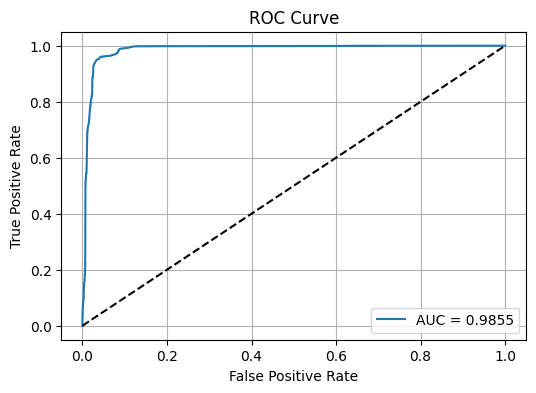

Best Threshold: 0.0202
Confusion Matrix:
[[17642  1772]
 [  702 66159]]

Classification Report:
              precision    recall  f1-score   support

      Benign       0.96      0.91      0.93     19414
   Anomalous       0.97      0.99      0.98     66861

    accuracy                           0.97     86275
   macro avg       0.97      0.95      0.96     86275
weighted avg       0.97      0.97      0.97     86275


Error Distribution
Benign samples: 19414
Anomalous samples: 66861


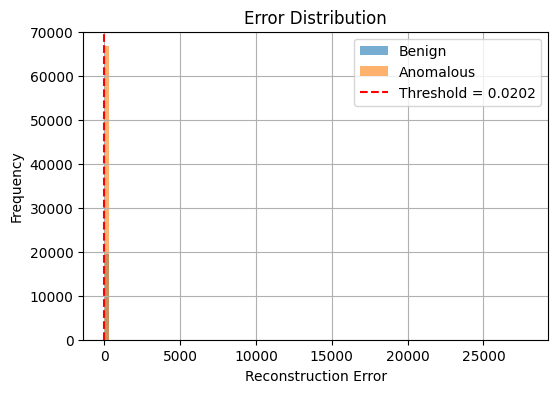

In [23]:
# Evaluate
errors, labels = evaluate_autoencoder(model, test_loader, device='cuda' if torch.cuda.is_available() else 'cpu')

# Find best threshold and show ROC/AUC
thresholds, roc_auc = plot_roc_auc(errors, labels)
best_threshold = find_best_threshold(errors, labels)
print(f"Best Threshold: {best_threshold:.4f}")

# Evaluate at best threshold
evaluate_predictions(errors, labels, best_threshold)


In [24]:
# Save model state dictionary
torch.save(model.state_dict(), 'simple_autoencoder.pth')